<h1 align="center">Unemployment & econometric learning</h1>
<h3 align="center">Daniel Schaefer & Carl Singleton</h3>
<h3 align="center">University of Edinburgh</h3>

Consistent with verison of the paper accepted for publication in Research in Economics in October 2017.

This notebook generates simulations and the main results contained within the forthcoming article, replicaitng all figures and saving them to your directory.
If you find any mistakes, or have any quesions regarding this replication file, please don't hesitate to contact us; carl.singleton@ed.ac.uk

In [1]:
# Import useful packages - set plots to generate within notebook
import numpy as np
import pandas as pd
from scipy import integrate, interpolate, linalg, optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Set parameter values for simulations
alpha= 0.67
beta = 0.67
mu = 0.56
y = 1
c = 0.25
lam = 0.023
r =(1-0.99)/0.99
d = 1/(1+r)
b = 0.8

In [3]:
# Defining some useful functions for plots - for given theta

def job_creation_curve(theta):
    """
   Deterministic Job Creation Curve
        theta:      abour market tightness 
    Returns:
        w:          equilibrium wage
    """

    # wage
    w = y - c*(r+lam)/(mu*theta**(-alpha))

    return w

def wage_curve(theta):
    """
    Deterministic Wage Curve
    Arguments:
        theta:      labour market tightness
    Returns:
        w:          equilibrium wage
    """
    
    # wage
    w = b+ beta*(y-b + c*theta)
    
    return w

def unemployment_rate(theta):
    
    """
   Arguments:
        theta:      labour market tightness    
    Returns:
      u:          (array-like) steady-state unemployment rate
    """
    
    # steady-state unemployment rate
    u = lam/(lam + mu*theta**(1-alpha))

    return u

def beveridge_curve(u):
    
    """
   Arguments:
        u:          labour market tightness     
    Returns:
        v:          unemployment rate
    """

    # unemployment rate
    
    v = (lam*(1 - u)/mu)**(1/(1-alpha))*(u**(-alpha/(1-alpha)))

    return v

def vacancy_rate(theta, u):
    
    """
   Arguments:
        theta:      labour market tightness
        u:          unemployment rate      
    Returns:
        v:          vacancy rate
        
    """
    # vacancy

    v = theta*u

    return v

In [4]:
# Solve for analytic equilibrium values of theta

from scipy.optimize import fsolve

def f_analytic_theta(theta):
    
    # wage
    x = (1-beta)*(y-b) - (r+lam)*c*theta**alpha/mu - beta*c*theta
    
    return x

from scipy.optimize import newton
analytic_theta = optimize.newton(func = f_analytic_theta, x0 = 0.5, tol=1.48e-08)

print(analytic_theta)

0.350339445526


In [5]:
# Use analytic_theta to solve for remainder of steady state equilibrium

print('Equilibrium Theta:', analytic_theta)
print('Equilibrium wage (1):', wage_curve(analytic_theta))
print('Equilibrium wage (2):', job_creation_curve(analytic_theta))
print('Equilibrium unemployment rate:', unemployment_rate(analytic_theta))
print('Equilibrium vacancy rate (1):', beveridge_curve(unemployment_rate(analytic_theta)))
# to check
print('Equilibrium vacancy rate (2):', vacancy_rate(analytic_theta, unemployment_rate(analytic_theta)))

('Equilibrium Theta:', 0.35033944552572394)
('Equilibrium wage (1):', 0.9926818571255588)
('Equilibrium wage (2):', 0.9926818571255588)
('Equilibrium unemployment rate:', 0.05487179295046886)
('Equilibrium vacancy rate (1):', 0.019223753517269595)
('Equilibrium vacancy rate (2):', 0.019223753517269588)


In [6]:
# Check equilibrium job finding rate

q = mu*analytic_theta**(-alpha)

print(q*analytic_theta)

0.396158893181


In [7]:
# Code non-detarministic parameters and parameters for first order approximation of the equation of motion for theta

# note for later, E-stability requires absolute value of psi2 less than 1
p = 0.84
ystar = y*(1-p)
sigma = 0.006
psi0 = analytic_theta*(1-(1-lam)*d + beta*mu*d*analytic_theta**(1-alpha)/alpha)-mu*(1-beta)*d/(c*alpha)*analytic_theta**(1-alpha)*y
psi1 = mu*(1-beta)*d/(c*alpha)*analytic_theta**(1-alpha)
psi2 = d*((1-lam) - beta*mu*analytic_theta**(1-alpha)/alpha)

print(psi0)
print(psi1)
print(psi2)

# Create additional useful parameters

tilde0 = psi0 + psi1*ystar*(1+p)
tilde1 = psi1*p**2
tilde2 = psi2

print(tilde0)
print(tilde1)
print(tilde2)

# More useful parameters - code A B C as parameters for the Rational Expectations Eq.

A = tilde0/(1-tilde2) + (tilde1*tilde2*ystar)/((1-tilde2)*(1-tilde2*p))
B = tilde1/(1-tilde2*p)
C = tilde1*tilde2/(1-tilde2*p) + psi1*p

print (A)
print (B)
print (C)

-0.623804416545
0.772687226283
0.57503269575
-0.396325297128
0.545208106865
0.57503269575
-0.70427771371
1.05461715924
1.25549661814


In [8]:
##### Coding The Rational Expectations Model

# define technology process - call variable yt to differentiate from paramter value in deterministic world

def Yt(yt, e):
    
    """
    Technology Process:
        y_{t+1} = y* + rho * y_t + epsilon_{t+1}
    Inputs:
        - current productivity, y_t
        - next productivity innovation, epsilon_{t+1}
    Returns:
        - next period's productivity
    """
    return ystar + p*yt + e

# define RE evolution of thetat

def Thetat(yt, e):
    
    """
    Rational expectations determination of theta
        theta_t = A + B y_t-1 + C eps_t
    Inputs:
        - previous productivity, y_t-1, and eps_t
    Returns:
        - current period's labour market tightness
    """ 
    
    return A + B*yt + C*e

In [9]:
# define 'implicit' function for evolution of unemployment

def Ut(ut, thetat):
    """
    Evolution of unemployment:
        u_{t+1} = (lambda)(1-u_t) + (1-theta_t*q(theta_t))u_t
    Inputs:
        - current unemployment, u_t
        - current tightness , theta_t
    Returns:
        - next period's unemployment
    """
    
    return lam*(1-ut) + (1-mu*thetat**(1-alpha))*ut

# define an 'explicit' function for evolution of unemployment so as to use minimum number of equations in updating

def Ut2(ut, yt, e):
    
    """
    Evolution of unemployment
        u_{t+1} = (lambda)(1-u_t) + (1-theta_t*q(theta_t))u_t
    Inputs:
        - previous productivity, y_t-1, and eps_t
        - current unemployment, u_t
    Returns:
        - next period's unemployment
    """
    
    return lam*(1-ut) + (1-mu*(A + B*yt + C*e)**(1-alpha))*ut

In [10]:
from scipy import stats

# Define a mean zero disribution of productivity shocks:

def eps():
    
    """
    Mean zero Gaussian disturbance term
    """
    
    shock = stats.norm(0, sigma)
    return shock.rvs(1)

In [11]:
#Build a simple SRS class to show updating of yt

"""
Simulating a stochastic version of the Search Match model using stochastic recursive sequences, with rational expectations
"""

class SRS1:
    """
    Class used to simulate stochastic models.
    """

    def __init__(self, F=None, X=None, e=0, eps=None, seed=None):
        """
        Represents the model X_{t+1} = F(X_{t}, e_{t+1})

        Atrributes:
            1) F is a function
            2) X is a number representing the initial condition of the endogenous variable
            3) e is a number representing the initial condition for the innovations
            4) eps is a function returning a draw from the distribution of innovations
        """
        self.F, self.X, self.e, self.eps = F, X, e, eps

        # initialize a seed 
        self.set_seed(seed)

    def set_seed(self, seed):
        """
        Sets the seed for the random number generator
        """
        self.seed = seed
        np.random.seed(int(self.seed))

    def update(self):
        """
        Updates the state variables according to X = F(X, e).
        The order of this updating process cannot be changed without impacting the
        timing of the model!
        """
        self.X = self.F(self.X, self.e)
        self.e = self.eps()

    def sample_path(self, n):
        """
        Generates path of length n for the endogenous variable, the stochastic shock
        process, and its innovation
        """
        path = np.zeros(shape=(n, 2))
        for t in range(n):
            path[t, 0] = self.X
            path[t, 1] = self.e
            self.update()
        return path

    def marginal(self, init=None, T=None, n=None):
        """
        Returns n draws of X_T, e_T starting from the states init = [X, e].
        """
        samples = np.zeros(shape=(n, 2))
        for i in range(n):
            self.X = init[0]
            self.e = init[1]
            for t in range(T):
                self.update()
            samples[i, 0] = self.X
            samples[i, 1] = self.e
        return samples

In [12]:
# Check it works...

# Create an instance of the SRS class to simulate the productivity process
TechProcess = SRS1(F=Yt, eps=eps, seed=42)

# Set some initial conditions
Y0 = y

# initialize X
TechProcess.X = Y0

# display the values of technology, its shock, and the seed
print ("Initial value for the level of productivity is: ", TechProcess.X)
print ("Value of the seed: ", TechProcess.seed)

#Check the updating procedure!
# store the current values of both productivity
Y_old = TechProcess.X

# update the SRS
TechProcess.update()

# store the new values of productivity, the shock, and its innovation
Y_new, e_new = TechProcess.X, TechProcess.e

# print new values
print ("New value for the level of productivity is: ", Y_new)
print ("New value for the innovation is: ", e_new) 

('Initial value for the level of productivity is: ', 1)
('Value of the seed: ', 42)
('New value for the level of productivity is: ', 1.0)
('New value for the innovation is: ', array([ 0.00298028]))


In [13]:
# Now build up the SRS class for the complete model under RE

# i.e. include equations for theta and unemployment

# We can then derive sample paths for wages and vacancies by imputting sample paths into wage curve and expression for v(theta,u)

"""
Simulating a stochastic version of the Search Match model using stochastic recursive sequences, with rational expectations
Requires three initial values - u, y, epsilon
"""

class SRS2:
    """
    Class used to simulate stochastic models.
    """

    def __init__(self, F=None, H=None, X=None, Z=None, e=0, eps=None, seed=None):
        """

        Atrributes:
            1) F is a function - AR Process
            3) H is a function - Unemployment
            2) X is a number representing the initial condition of the endogenous variable - y
            2) Z is a number representing the initial condition of the endogenous variable - u
            3) e is a number representing the initial condition for the innovations
            4) eps is a function returning a draw from the distribution of innovations
        """
        self.F, self.H, self.X, self.Z, self.e, self.eps = F, H, X, Z, e, eps

        # initialize a seed
        self.set_seed(seed)

    def set_seed(self, seed):
        """
        Sets the seed for the random number generator
        """
        self.seed = seed
        np.random.seed(int(self.seed))

    def update(self):
        """
        Updates the state variables according to X = F(X, e) and Z = H(Z, X, e).
        The order of this updating process cannot be changed without impacting the
        timing of the model!
        """       
        self.Z = self.H(self.Z, self.X, self.e)  
        self.X = self.F(self.X, self.e)
        self.e = self.eps()        
        
        
    def sample_path(self, n):
        """
        Generates path of length n for the endogenous variables       
        """
        path = np.zeros(shape=(n, 3))
        for t in range(n):
            path[t, 0] = self.X
            path[t, 1] = self.e
            path[t, 2] = self.Z
            self.update()
        return path

    def marginal(self, init=None, T=None, n=None):
        """
        Returns n draws of X_T, Z_T, e_T starting from the states init = [X, e, Z].
        """
        samples = np.zeros(shape=(n, 3))
        for i in range(n):
            self.X = init[0]
            self.e = init[1]
            self.Z = init[2]
            for t in range(T):
                self.update()
            samples[i, 0] = self.X
            samples[i, 1] = self.e
            samples[i, 2] = self.Z
        return samples

In [14]:
RE = SRS2(F=Yt, H=Ut2, eps=eps, seed=42)

# Set some initial conditions (stop and think about what REASONABLE initial conditions might be!
# note initial condition for e1 always set to zero)
Y0 = y
U1 = unemployment_rate(analytic_theta)

# initialize X, and Z
RE.X = Y0
RE.Z = U1

# display the initial values, and the seed
print ("Initial value for the level of productivity is: ", RE.X)
print ("Initial value for the level of unemployment is: ", RE.Z)
print ("Value of the seed: ", RE.seed)

#Check the updating procedure!

# store the current values 
Y0 = RE.X
U1 = RE.Z
e1 = 0.0

# update the SRS
RE.update()

# store the new values
Y1, U2, e2 = RE.X, RE.Z, RE.e

# print new values
print ("New value for the level of productivity is: ", Y1)
print ("New value for the level of unemploment is: ", U2)
print ("New value for the innovation is: ", e2 )

('Initial value for the level of productivity is: ', 1)
('Initial value for the level of unemployment is: ', 0.05487179295046886)
('Value of the seed: ', 42)
('New value for the level of productivity is: ', 1.0)
('New value for the level of unemploment is: ', 0.05487179295046886)
('New value for the innovation is: ', array([ 0.00298028]))


In [15]:
# Recovering the trajectory of wages from the sample path

def wage_curve2(yt, theta, e):
    
    # wage
    w = b + beta*(ystar+p*yt+e - b + c*theta)
    
    return w

In [16]:
#Check - note, first value of theta is theta_1, this is because eventually we are going to be using A_0 , B_0 to predict

print("theta1", Thetat(Y0 , e1))

print ("theta2", Thetat(Y1 , e2))

print ("U2", Ut(U1, Thetat(Y0 , e1)))

print ("U3", Ut(U1, Thetat(Y1 , e2)))

print ("w1", wage_curve2(Y0, Thetat(Y0 , e1), e1))

print ("w2", wage_curve2(Y1, Thetat(Y1 , e2), e2))

('theta1', 0.3503394455257238)
('theta2', array([ 0.35408118]))
('U2', 0.05487179295046886)
('U3', array([ 0.05479545]))
('w1', 0.9926818571255588)
('w2', array([ 0.99530539]))


In [17]:
# Reset & Generate a x period sample path

RE = SRS2(F=Yt, H=Ut2, eps=eps, seed=42)

# Set some initial conditions 
Y0 = y
U1 = unemployment_rate(analytic_theta)

# initialize X, and Z
RE.X = Y0
RE.Z = U1

RE_samplepath = RE.sample_path(100)

C:\Users\s1052956\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


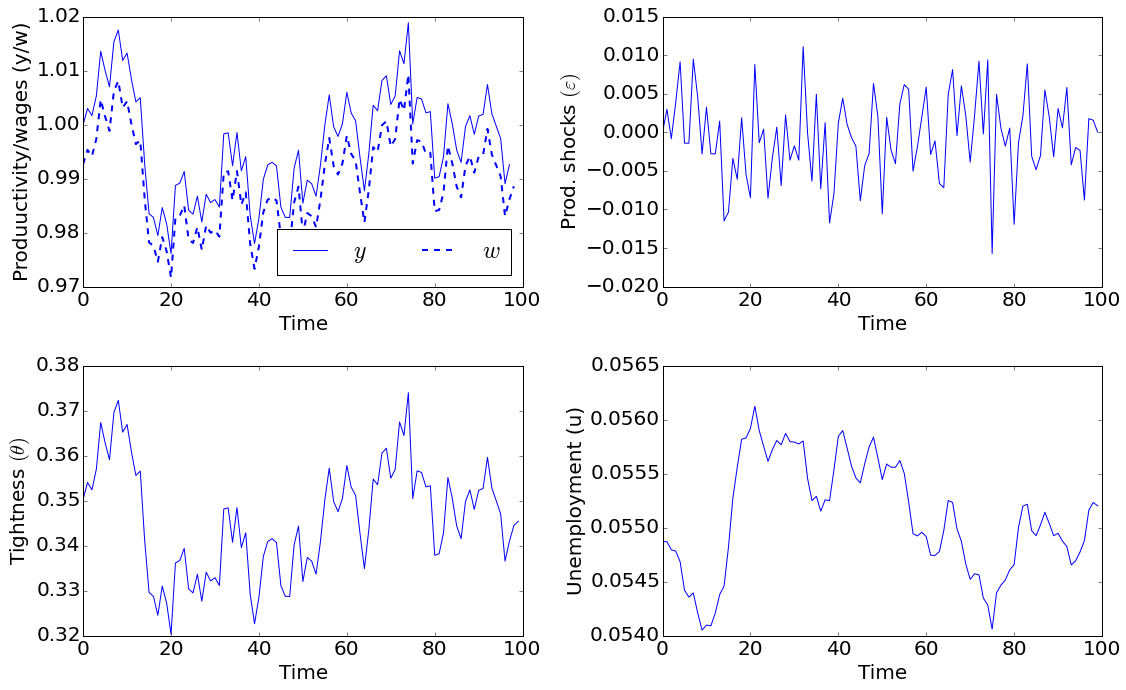

In [18]:
# Generate Plots of the RE Equilibrium sample path (Figure C1)

# Plot the results - If playing around with param values need to change ymin & ymax
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)
# Create a new plot
plt.figure(num=None, figsize=(16, 10), dpi=200, facecolor='w', edgecolor='k')

# Add a subplot
plt.subplot(221)

# Add a title to the plot
#plt.title('RE: The evolution of output (productivity), wages, tightness, unemployment and shocks')

# Plot the sample path of aggregate output, Y / productivity
plt.plot(RE_samplepath[1:99, 0], label=r'$y$')
plt.plot(wage_curve2(RE_samplepath[0:99, 0],Thetat(RE_samplepath[0:99, 0],RE_samplepath[0:99, 1]),RE_samplepath[0:99, 1]), label=r'$w$', color='b', ls='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Produuctivity/wages (y/w)')

#plt.xlim(xmin=1)
plt.legend(loc=4, ncol=2)

# Add a subplot
plt.subplot(223)

# Plot the sample path of theta
plt.plot(Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]), label=r'$\theta$')
plt.xlabel('Time')
plt.ylabel('Tightness' ' ' r'$(\theta)$')

# Add a subplot
plt.subplot(224)

# Plot the sample path of unemployment
plt.plot(RE_samplepath[:, 2], label=r'$u$')
plt.xlabel('Time')
plt.ylabel('Unemployment (u)')

# Add a subplot
plt.subplot(222)

# Plot the sample path shocks
plt.plot(RE_samplepath[:, 1], label=r'$\varepsilon$: $\sigma=0.006$')

plt.xlabel('Time')
plt.ylabel('Prod. shocks' ' ' r'$(\varepsilon)$')

plt.tight_layout()

plt.savefig('FigureC1.png')

In [19]:
# compute standard errors etc.
# Wages
print (np.std(wage_curve2(RE_samplepath[0:20, 0],Thetat(RE_samplepath[0:20, 0],RE_samplepath[0:20, 1]),RE_samplepath[0:20, 1])))
print (np.std(wage_curve2(RE_samplepath[:, 0],Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]),RE_samplepath[:, 1])))
print (np.min(wage_curve2(RE_samplepath[:, 0],Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]),RE_samplepath[:, 1])))
print (np.max(wage_curve2(RE_samplepath[:, 0],Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]),RE_samplepath[:, 1])))

#Theta
print (np.std(Thetat(RE_samplepath[0:20, 0],RE_samplepath[0:20, 1])))
print (np.std(Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1])))
print (np.min(Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1])))
print (np.max(Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1])))
                
#Unemployment
print (np.std(RE_samplepath[0:20, 2]))
print (np.std(RE_samplepath[:, 2]))
print (np.min(RE_samplepath[:, 2]))
print (np.max(RE_samplepath[:, 2]))

0.0106685481572
0.00849077328729
0.971651478166
1.00928276269
0.0152157126091
0.0121097232974
0.320345467189
0.37401601373
0.000537035113909
0.000525151867422
0.0540527554933
0.0561256974444


In [20]:
# Now we begin to add learning to the model - Recursive Least Squares

## Code up the Actual Law of Motion (ALM) for theta

def thetaALM(yt, e, A, B):
    """
    """   
    return (tilde0 + tilde2*A + tilde2*B*ystar) + (tilde1 + tilde2*B*p)*yt + (tilde2*B + psi1*p)*e

## Code up the ALM for unemployment

def utALM(yt, e, x, ut):
    
    """
    Note, x is column vector of estiamtes   
    """
    
    A = x.item(0)
    B = x.item(1)
     
    return (lam)*(1-ut) + (1-mu*((tilde0 + tilde2*A + tilde2*B*ystar) + (tilde1 + tilde2*B*p)*yt + (tilde2*B + psi1*p)*e)**(1-alpha))*ut

# Code in updating expression for gamma_t - updating time period - RLS

def t(t):

    return (t+1)

# Code in updating equation for R

def Rt(Rt , yt , t):

    z = np.array( [[1.0],[yt]])
    zT = np.transpose(z)
    zzT = np.dot(z,zT)
    
    return Rt + (1/t)*(zzT - Rt)

# Code in Estimates equation

def xt(Rt , yt , t , e , x):

    A = x.item(0)
    B = x.item(1)
    z = np.array( [[1],[yt]])
    zT = np.transpose(x)
    zTx = np.dot(zT,z)
    Rinv = np.linalg.inv(Rt)
    Rinvz = np.dot(Rinv,z)

    return x + (1/t)*Rinvz*((tilde0 + tilde2*A + tilde2*B*ystar) + (tilde1 + tilde2*B*p)*yt - zTx + (tilde2*B + psi1*p)*e)

In [21]:
# Now code the updating class.

"""
Simulating a stochastic version of the Search Match model using stochastic recursive sequences, and Recursive Least Squares Learning
Requires three initial values - u, y, epsilon,
"""

class SRS3:
    """
    Class used to simulate stochastic models.
    """

    def __init__(self, Y=None, T=None, X=None, R=None, U=None, y=None, t=None, x=None, r=None, u=None, e=0, eps=None, seed=None):
        """

        Atrributes:
            1) Y is a function - AR Process
            2) T is a function - Time
            3) X is a function - Estimate Updating
            4) R is a function - Covariance updating
            5) U is a function - Unemployment updating            
            6) y is a number representing the initial condition of y
            7) t is a number representing the initial condition of t
            8) x is a vector representing the initial condition of the coefficient estimates
            9) r is a matrix representing the initial condition of the coefficient estimate covariances
            10) u is a number representing the initial condition of u
            11) e is a number representing the initial condition for the innovations
            12) eps is a function returning a draw from distribution of innovations
        """
        self.Y, self.T, self.X, self.R, self.U, self.y, self.t, self.x, self.r, self.u, self.e, self.eps = Y, T, X, R, U, y, t, x, r, u, e, eps

        # initialize a seed the seed
        self.set_seed(seed)

    def set_seed(self, seed):
        """
        Sets the seed for the random number generator
        """
        self.seed = seed
        np.random.seed(int(self.seed))

    def update(self):
        """
        The order of this updating process cannot be changed without impacting the
        timing of the model!
        """       
        
        self.u = self.U(self.y, self.e, self.x, self.u)
        self.r = self.R(self.r, self.y, self.t)
        self.x = self.X(self.r, self.y, self.t, self.e, self.x)     
        self.t = self.T(self.t)
        self.y = self.Y(self.y, self.e)
        self.e = self.eps()  
        
        
    def sample_path(self, n):
        """
        Generates path of length n for the endogenous variables
        Note: Don't try to jam arrays into elements of the matrix
        b0=b.item(1)
        """
        path = np.zeros(shape=(n, 10))
        for t in range(n):
            path[t, 0] = self.u
            path[t, 1] = self.e
            path[t, 2] = self.t
            path[t, 3] = self.r.item(0)
            path[t, 4] = self.r.item(1)
            path[t, 5] = self.r.item(2)
            path[t, 6] = self.r.item(3)
            path[t, 7] = self.x.item(0)
            path[t, 8] = self.x.item(1)
            path[t, 9] = self.y
            self.update()
        return path

In [22]:
Learning = SRS3(Y=Yt, T=t, X=xt, R=Rt, U=utALM, eps=eps, seed=42)

# Set some initial conditions (stop and think about what REASONABLE initial conditions might be!)
# Use those as estimated for S0

# Let agents actually know RE A and B in initial period

x = np.array([[tilde0/(1-tilde2) + (tilde1*tilde2*ystar)/((1-tilde2)*(1-tilde2*p))],[tilde1/(1-tilde2*p)]])
x = x.astype(float) 
y0 = y
z0 = np.array( [[1.0],[y0]])
z0T = np.transpose(z0)
z0z0T = np.dot(z0,z0T)
u1 = lam/(lam+mu*thetaALM(y, 0, x.item(0), x.item(1))**(1-alpha))
S0 = np.array([[50.0,50.0],[50.0,50.075]])
S0 = S0.astype(float)
r0 = S0*0.02
x0 = x
t0=51

# initialize X, Y and Z
Learning.y = y0
Learning.x = x0
Learning.t = t0
Learning.r = r0
Learning.u = u1

# display the initial values, and the seed
print ("Initial value for the level of productivity is: ", Learning.y)
print ("Initial value for the level of unemployment is: ", Learning.u)
print ("Initial R matrix is: ", Learning.r)
print ("Initial vector estimate: ", Learning.x)
print ("Initial t: ", Learning.t)
print ("Value of the seed: ", Learning.seed)

Learning_samplepath = Learning.sample_path(100)

('Initial value for the level of productivity is: ', 1)
('Initial value for the level of unemployment is: ', 0.05487179295046887)
('Initial R matrix is: ', array([[ 1.    ,  1.    ],
       [ 1.    ,  1.0015]]))
('Initial vector estimate: ', array([[-0.70427771],
       [ 1.05461716]]))
('Initial t: ', 51)
('Value of the seed: ', 42)


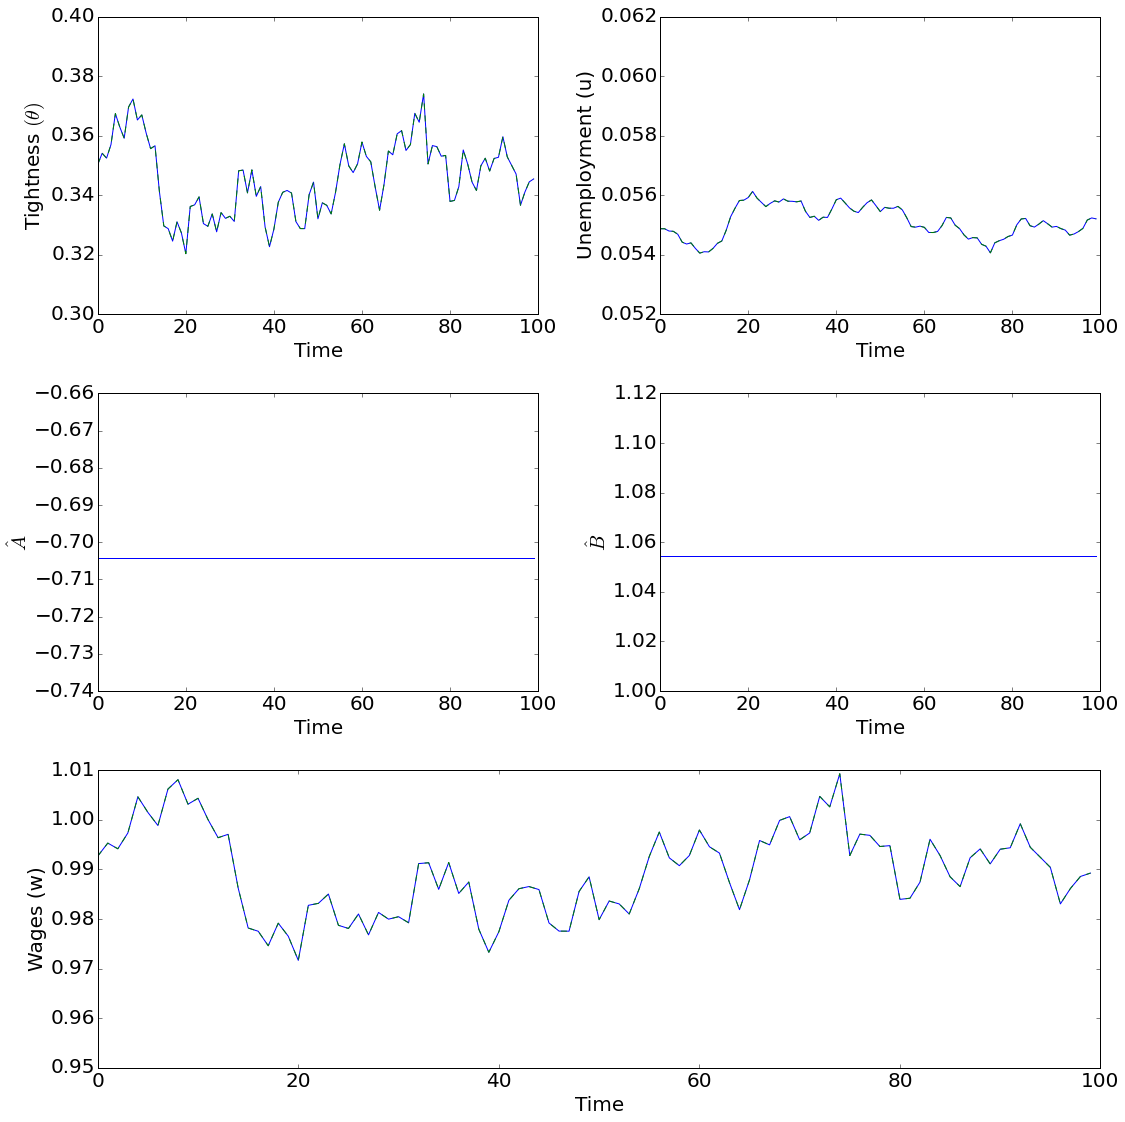

In [23]:
# Plot the results - Add RE on top - Figure not listed in paper, this is a Check Exercise to ensure sample paths align

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)

# Create a new plot
plt.figure(num=None, figsize=(16, 16), dpi=200, facecolor='w', edgecolor='k')

# Add a subplot
plt.subplot(313)

# Plot the sample path of wages
plt.plot(wage_curve2(Learning_samplepath[:, 9], thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8]), Learning_samplepath[:, 1]), label=r'w')
plt.plot(wage_curve2(RE_samplepath[:, 0],Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]),RE_samplepath[:, 1]), label=r'$w_{RE}$', ls='--')
plt.xlabel('Time')
plt.ylabel('Wages (w)')

plt.ylim(ymin=0.95)
plt.ylim(ymax=1.01)

# Add a subplot
plt.subplot(321)

# Plot the sample path of theta
plt.plot(thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8]), label=r'$\theta$')
plt.plot(Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]), label=r'$\theta_{RE}$', ls='--')
plt.xlabel('Time')
plt.ylabel('Tightness' ' ' r'$(\theta)$')

plt.ylim(ymin=0.3)
plt.ylim(ymax=0.4)

# Add a subplot
plt.subplot(322)

# Plot the sample path of unemployment
plt.plot(Learning_samplepath[:, 0], label=r'$u$')
plt.plot(RE_samplepath[:, 2], label=r'$u_{RE}$', ls='--')
plt.xlabel('Time')
plt.ylabel('Unemployment (u)')

plt.ylim(ymin=0.052)
plt.ylim(ymax=0.062)

# Add a subplot
plt.subplot(323)

# Plot the sample path A estimate
plt.plot(Learning_samplepath[:, 7], label=r'$\hat{A}$')


plt.xlabel('Time')
plt.ylabel(r'$\hat{A}$')

# Add a subplot
plt.subplot(324)

# Plot the sample path B estimate
plt.plot(Learning_samplepath[:, 8], label=r'$\hat{B}$')


plt.xlabel('Time')
plt.ylabel(r'$\hat{B}$')

plt.tight_layout()

plt.savefig('Final_REComparison (1).png')


In [24]:
#Check the updating procedure!

# store the current values 
y_old = Learning.y
u_old = Learning.u
t_old = Learning.t
r_old = Learning.r
x_old = Learning.x

# update the SRS
Learning.update()

# store the new values
y_new, u_new, t_new, r_new, x_new, e_new = Learning.y, Learning.u, Learning.t, Learning.r, Learning.x, Learning.e

# print new values
print (y_new)
print (u_new)
print (e_new) 
print (r_new)
print (x_new)
print (t_new)

[ 0.99532472]
[ 0.05516414]
[-0.00849222]
[[ 1.      1.    ]
 [ 1.      1.0015]]
[[-0.70427771]
 [ 1.05461716]]
152


In [25]:
# Re-initialise and create sample path

Learning = SRS3(Y=Yt, T=t, X=xt, R=Rt, U=utALM, eps=eps, seed=42)

# Set initial conditions 

x = np.array([[analytic_theta-1.77],[1.77]])
x = x.astype(float) 
y0 = y
z0 = np.array( [[1.0],[y0]])
z0T = np.transpose(z0)
z0z0T = np.dot(z0,z0T)
u1 = u1 = lam/(lam+mu*thetaALM(y, 0, x.item(0), x.item(1))**(1-alpha))
S0 = np.array([[49.0,49.00],[49.00,49.0684]])
S0 = S0.astype(float)
r0 = S0/49
x0 = x
t0= 50.0

# initialize X, Y and Z
Learning.y = y0
Learning.x = x0
Learning.t = t0
Learning.r = r0
Learning.u = u1

# display the initial values, and the seed
print ("Initial value for the level of productivity is: ", Learning.y)
print ("Initial value for the level of unemployment is: ", Learning.u)
print ("Initial R matrix is: ", Learning.r)
print ("Initial vector estimate: ", Learning.x)
print("Initial t: ", Learning.t)
print ("Value of the seed: ", Learning.seed)

Learning_samplepath = Learning.sample_path(100)

('Initial value for the level of productivity is: ', 1)
('Initial value for the level of unemployment is: ', 0.05487179295046887)
('Initial R matrix is: ', array([[ 1.        ,  1.        ],
       [ 1.        ,  1.00139592]]))
('Initial vector estimate: ', array([[-1.41966055],
       [ 1.77      ]]))
('Initial t: ', 50.0)
('Value of the seed: ', 42)


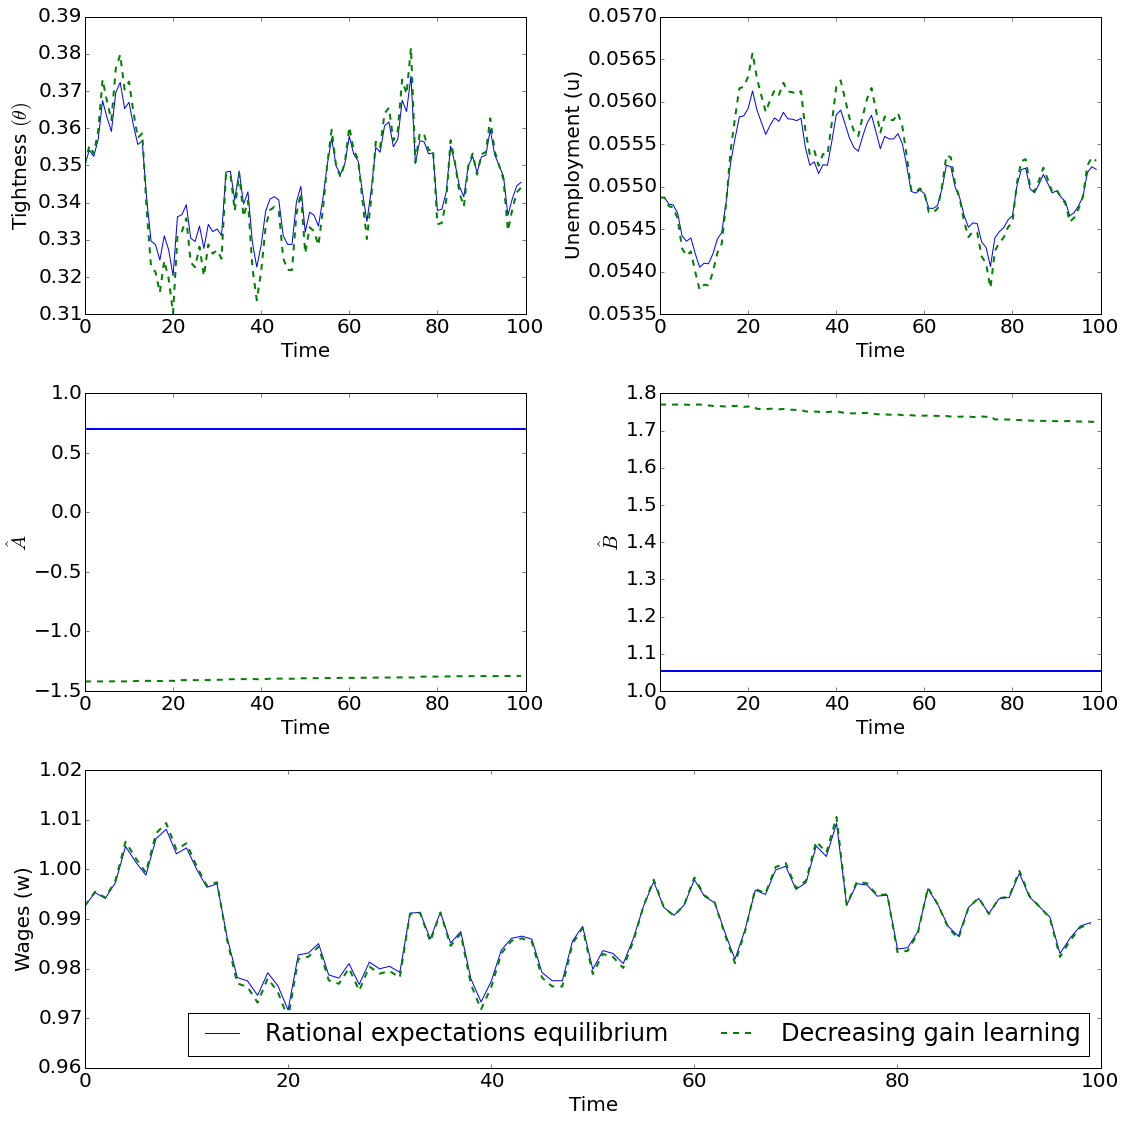

In [26]:
# Plot the results - Add RE on top - (This Figure is not in the paper)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)

# Create a new plot
plt.figure(num=None, figsize=(16, 16), dpi=200, facecolor='w', edgecolor='k')

# Add a subplot
plt.subplot(313)

# Plot the sample path of wages
plt.plot(wage_curve2(RE_samplepath[:, 0],Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]),RE_samplepath[:, 1]), label='Rational expectations equilibrium')
plt.plot(wage_curve2(Learning_samplepath[:, 9], thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8]), Learning_samplepath[:, 1]), label='Decreasing gain learning', ls='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Wages (w)')
plt.legend(loc=4, ncol=2)

# Add a subplot
plt.subplot(321)

# Plot the sample path of theta
plt.plot(Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]), label=r'$\theta_{RE}$')
plt.plot(thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8]), label=r'$\theta$', ls='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Tightness' ' ' r'$(\theta)$')


# Add a subplot
plt.subplot(322)

# Plot the sample path of unemployment
plt.plot(RE_samplepath[:, 2], label=r'$u_{RE}$')
plt.plot(Learning_samplepath[:, 0], label=r'$u$', ls='--', linewidth=2)
# Add a subplot
plt.xlabel('Time')
plt.ylabel('Unemployment (u)')


# Add a subplot
plt.subplot(323)

# Plot the sample path A estimate
plt.plot(Learning_samplepath[:, 7], label=r'$\hat{A}$', ls='--', color='g', linewidth=2)
plt.axhline(y=--0.70427771371, xmin=0, xmax=99, linewidth=2, color = 'b')
plt.xlabel('Time')
plt.ylabel(r'$\hat{A}$')

# Add a subplot
plt.subplot(324)

# Plot the sample path B estimate
plt.plot(Learning_samplepath[:, 8], label=r'$\hat{B}$', ls='--', color='g', linewidth=2)
plt.axhline(y=1.05461715924, xmin=0, xmax=99, linewidth=2, color = 'b')

plt.xlabel('Time')
plt.ylabel(r'$\hat{B}$')

plt.tight_layout()

plt.savefig('Final_Example(1,1).png')



In [27]:
# compute standard errors etc.
# Wages
print (np.std(wage_curve2(Learning_samplepath[0:20, 9], thetaALM(Learning_samplepath[0:20, 9], Learning_samplepath[0:20, 1], Learning_samplepath[0:20, 7], Learning_samplepath[0:20, 8]), Learning_samplepath[0:20, 1])))
print (np.std(wage_curve2(Learning_samplepath[:, 9], thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8]), Learning_samplepath[:, 1])))
print (np.min(wage_curve2(Learning_samplepath[:, 9], thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8]), Learning_samplepath[:, 1])))
print (np.max(wage_curve2(Learning_samplepath[:, 9], thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8]), Learning_samplepath[:, 1])))

#Theta
print (np.std(thetaALM(Learning_samplepath[0:20, 9], Learning_samplepath[0:20, 1], Learning_samplepath[0:20, 7], Learning_samplepath[0:20, 8])))
print (np.std(thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8])))
print (np.min(thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8])))
print (np.max(thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8])))
                
#Unemployment
print (np.std(Learning_samplepath[0:20, 0]))
print (np.std(Learning_samplepath[:, 0]))
print (np.min(Learning_samplepath[:, 0]))
print (np.max(Learning_samplepath[:, 0]))

0.0115292046099
0.00915821358186
0.969970060736
1.01056017624
0.0203540460076
0.0160948780394
0.310307154176
0.381642363272
0.000720097393799
0.000702727793291
0.0537868985845
0.0565733493872


In [28]:
## Next, extend the sample paths for Example 1 and REE to illustrate convergence

# Reset & Generate a x period sample path

RE2 = SRS2(F=Yt, H=Ut2, eps=eps, seed=42)

# Set some initial conditions 
Y0 = y
U1 = u1 = lam/(lam+mu*thetaALM(y, 0, x.item(0), x.item(1))**(1-alpha))

# initialize X, and Z
RE2.X = Y0
RE2.Z = U1

RE2_samplepath = RE2.sample_path(10000)

In [29]:
# Re-initialise and create sample path - extend length of sample path to check convergence of parameter estimates...

Learning2 = SRS3(Y=Yt, T=t, X=xt, R=Rt, U=utALM, eps=eps, seed=42)

# Set initial conditions

x = np.array([[analytic_theta-1.77],[1.77]])
x = x.astype(float) 
y0 = y
z0 = np.array( [[1.0],[y0]])
z0T = np.transpose(z0)
z0z0T = np.dot(z0,z0T)
u1 = u1 = lam/(lam+mu*thetaALM(y, 0, x.item(0), x.item(1))**(1-alpha))
S0 = np.array([[49.0,49.00],[49.00,49.0684]])
S0 = S0.astype(float)
r0 = S0/49
x0 = x
t0= 50.0

# initialize X, Y and Z
Learning2.y = y0
Learning2.x = x0
Learning2.t = t0
Learning2.r = r0
Learning2.u = u1

# display the values of technology, its shock, and the seed
print ("Initial value for the level of productivity is: ", Learning2.y)
print ("Initial value for the level of unemployment is: ", Learning2.u)
print ("Initial R matrix is: ", Learning2.r)
print ("Initial vector estimate: ", Learning2.x)
print ("Initial t: ", Learning2.t)
print ("Value of the seed: ", Learning2.seed)

Learning2_samplepath = Learning2.sample_path(10000)

('Initial value for the level of productivity is: ', 1)
('Initial value for the level of unemployment is: ', 0.05487179295046887)
('Initial R matrix is: ', array([[ 1.        ,  1.        ],
       [ 1.        ,  1.00139592]]))
('Initial vector estimate: ', array([[-1.41966055],
       [ 1.77      ]]))
('Initial t: ', 50.0)
('Value of the seed: ', 42)


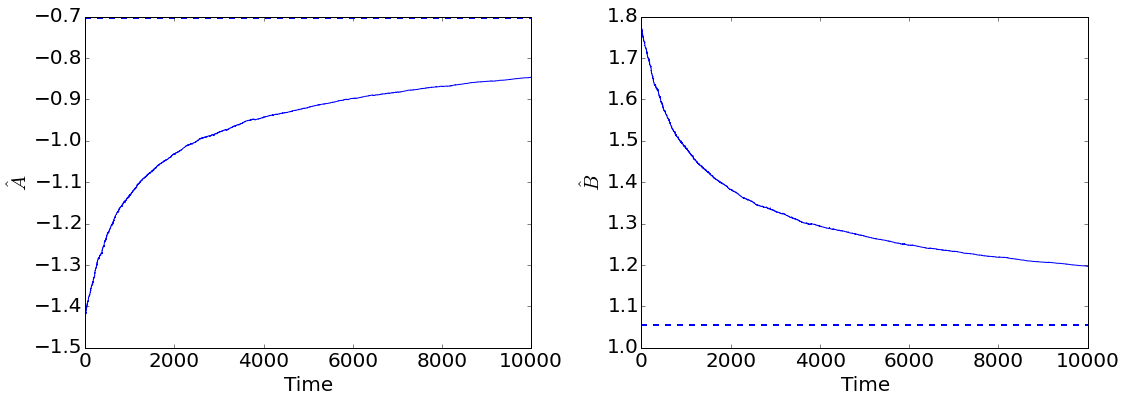

In [30]:
# Graph Convergence result - Figure C2

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)

# Plot the results - Add RE on top

# Create a new plot
plt.figure(num=None, figsize=(16, 6), dpi=200, facecolor='w', edgecolor='k')

#plt.title('Learning Example 1: Illustrating the eventual convergence of parameter estimates')

# Add a subplot
plt.subplot(121)

# Plot the sample path A estimate
plt.plot(Learning2_samplepath[:, 7], label=r'$\hat{A}$')
plt.axhline(y=-0.70427771371, xmin=0, xmax=99, linewidth=2, color = 'b', ls='--')
plt.xlabel('Time')
plt.ylabel(r'$\hat{A}$')

# Add a subplot
plt.subplot(122)

# Plot the sample path B estimate
plt.plot(Learning2_samplepath[:, 8], label=r'$\hat{B}$')
plt.axhline(y=1.05461715924, xmin=0, xmax=99, linewidth=2, color = 'b', ls='--')
plt.xlabel('Time')
plt.ylabel(r'$\hat{B}$')

plt.tight_layout()

plt.savefig('FigureC2.png')


In [31]:
### Now Show Learning Example 2 -  a 20% shock to flow value of unemployment
## Remember to change analytic theta

b = 0.64

# Solve for analytic equilibrium values of theta etc.

from scipy.optimize import fsolve

def f_analytic_theta(theta):
    """
       
    Returns:

    """
    
    # wage
    x = (1-beta)*(y-b) - (r+lam)*c*theta**alpha/mu - beta*c*theta
    
    return x

from scipy.optimize import newton
analytic_theta = optimize.newton(func = f_analytic_theta, x0 = 1, tol=1.48e-08)

print (analytic_theta)

psi0 = analytic_theta*(1-(1-lam)*d + beta*mu*d*analytic_theta**(1-alpha)/alpha)-mu*(1-beta)*d/(c*alpha)*analytic_theta**(1-alpha)*y
psi1 = mu*(1-beta)*d/(c*alpha)*analytic_theta**(1-alpha)
psi2 = (1-lam)*d - beta*mu*d*analytic_theta**(1-alpha)/alpha
tilde0 = psi0 + psi1*ystar*(1+p)
tilde1 = psi1*p**2
tilde2 = psi2
A = tilde0/(1-tilde2) + (tilde1*tilde2*ystar)/((1-tilde2)*(1-tilde2*p))
B = tilde1/(1-tilde2*p)
C = tilde1*tilde2/(1-tilde2*p) + psi1*p
print (A)
print (B)
print tilde2

0.643587016396
-0.485503646305
1.1290906627
0.487867979675


In [32]:
# Reset & Generate a x period sample path

RE3 = SRS2(F=Yt, H=Ut2, eps=eps, seed=42)

# Set some initial conditions 
Y0 = y
U1 = 0.05487179295046886 # start at old RE equilibrium

# initialize X, and Z
RE3.X = Y0
RE3.Z = U1

RE3_samplepath = RE3.sample_path(100)

In [33]:
# Re-initialise and create sample path - extend length of sample path to check convergence of parameter estimates...

Learning3 = SRS3(Y=Yt, T=t, X=xt, R=Rt, U=utALM, eps=eps, seed=42)

# Set initial conditions - start at old RE equilibrium   
    
x = np.array([[-0.70427771371],[1.05461715924]])
x = x.astype(float) 
y0 = y
z0 = np.array( [[1.0],[y0]])
z0T = np.transpose(z0)
z0z0T = np.dot(z0,z0T)
u1 = 0.05487179295046886
S0 = np.array([[1.0,1.00],[1.00,1.01]])
S0 = S0.astype(float)
r0 = S0*1
x0 = x
t0= 2.0

# initialize X, Y and Z
Learning3.y = y0
Learning3.x = x0
Learning3.t = t0
Learning3.r = r0
Learning3.u = u1

# display the initial values, and the seed
print ("Initial value for the level of productivity is: ", Learning3.y)
print ("Initial value for the level of unemployment is: ", Learning3.u)
print ("Initial R matrix is: ", Learning3.r)
print ("Initial vector estimate: ", Learning3.x)
print ("Initial t: ", Learning3.t)
print ("Value of the seed: ", Learning3.seed)

Learning3_samplepath = Learning3.sample_path(100)

('Initial value for the level of productivity is: ', 1)
('Initial value for the level of unemployment is: ', 0.05487179295046886)
('Initial R matrix is: ', array([[ 1.  ,  1.  ],
       [ 1.  ,  1.01]]))
('Initial vector estimate: ', array([[-0.70427771],
       [ 1.05461716]]))
('Initial t: ', 2.0)
('Value of the seed: ', 42)


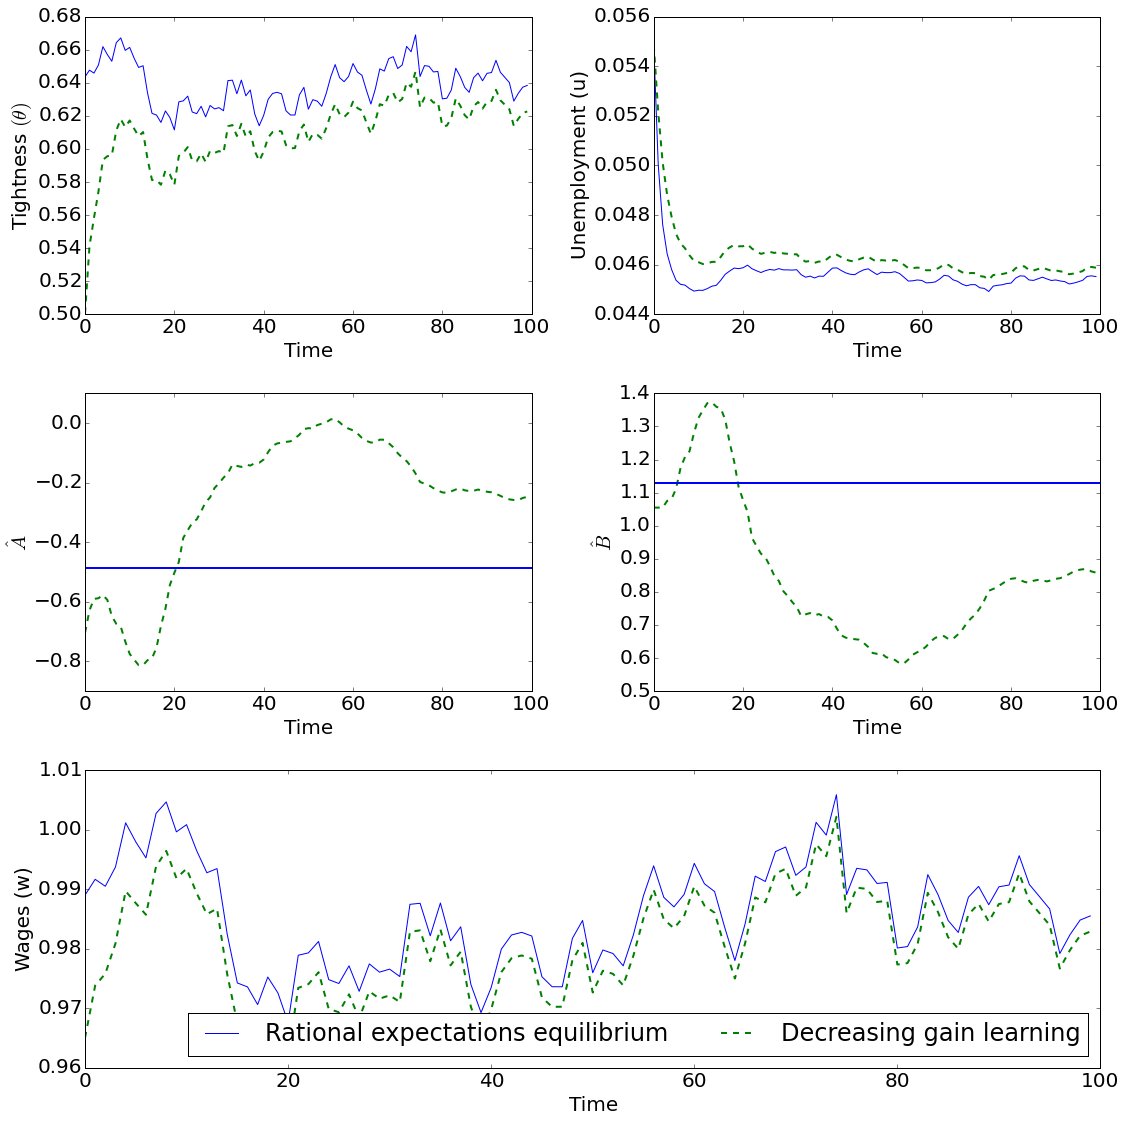

In [34]:
# Plot the results - Add RE on top - Figure C3

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)

# Create a new plot
plt.figure(num=None, figsize=(16, 16), dpi=200, facecolor='w', edgecolor='k')

#plt.title('Learning Example 2: The evolution of output (productivity), wages, tightness, unemployment and shocks')

# Add a subplot
plt.subplot(313)

# Plot the sample path of wages
plt.plot(wage_curve2(RE3_samplepath[:, 0],Thetat(RE3_samplepath[:, 0],RE3_samplepath[:, 1]),RE3_samplepath[:, 1]), label='Rational expectations equilibrium')
plt.plot(wage_curve2(Learning3_samplepath[:, 9], thetaALM(Learning3_samplepath[:, 9], Learning3_samplepath[:, 1], Learning3_samplepath[:, 7], Learning3_samplepath[:, 8]), Learning3_samplepath[:, 1]), label='Decreasing gain learning', ls='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Wages (w)')
plt.legend(loc=4, ncol=2)

# Add a subplot
plt.subplot(321)

# Plot the sample path of theta
plt.plot(Thetat(RE3_samplepath[:, 0],RE3_samplepath[:, 1]), label=r'$\theta_{RE}$')
plt.plot(thetaALM(Learning3_samplepath[:, 9], Learning3_samplepath[:, 1], Learning3_samplepath[:, 7], Learning3_samplepath[:, 8]), label=r'$\theta$', ls='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Tightness' ' ' r'$(\theta)$')

# Add a subplot
plt.subplot(322)

# Plot the sample path of unemployment
plt.plot(RE3_samplepath[:, 2], label=r'$u_{RE}$')
plt.plot(Learning3_samplepath[:, 0], label=r'$u$', ls='--', linewidth=2)
# Add a subplot
plt.xlabel('Time')
plt.ylabel('Unemployment (u)')


# Add a subplot
plt.subplot(323)

# Plot the sample path A estimate
plt.plot(Learning3_samplepath[:, 7], label=r'$\hat{A}$', ls='--', color='g', linewidth=2)
plt.axhline(y=-0.485503646305, xmin=0, xmax=99, linewidth=2, color = 'b')
plt.xlabel('Time')
plt.ylabel(r'$\hat{A}$')

# Add a subplot
plt.subplot(324)

# Plot the sample path B estimate
plt.plot(Learning3_samplepath[:, 8], label=r'$\hat{B}$', ls='--', color='g', linewidth=2)
plt.axhline(y=1.1290906627, xmin=0, xmax=99, linewidth=2, color = 'b')
plt.xlabel('Time')
plt.ylabel(r'$\hat{B}$')

plt.tight_layout()

plt.savefig('FigureC3.png')

In [35]:
# Illustrate change in speed of convergence - change beta - 0.1

In [36]:
b = 0.8
alpha=0.67
beta = 0.1


c = 2.80140095

# Solve for analytic equilibrium values of theta

from scipy.optimize import fsolve

def f_analytic_theta(theta):
    """    
    Returns:
    """
    
    # wage
    x = (1-beta)*(y-b) - (r+lam)*c*theta**alpha/mu - beta*c*theta
    
    return x

from scipy.optimize import newton
analytic_theta = optimize.newton(func = f_analytic_theta, x0 = 0.06, tol=1.48e-08)

print (analytic_theta)

psi0 = analytic_theta*(1-(1-lam)*d + beta*mu*d*analytic_theta**(1-alpha)/alpha)-mu*(1-beta)*d/(c*alpha)*analytic_theta**(1-alpha)*y
psi1 = mu*(1-beta)*d/(c*alpha)*analytic_theta**(1-alpha)
psi2 = (1-lam)*d - beta*mu*d*analytic_theta**(1-alpha)/alpha
tilde0 = psi0 + psi1*ystar*(1+p)
tilde1 = psi1*p**2
tilde2 = psi2
A = tilde0/(1-tilde2) + (tilde1*tilde2*ystar)/((1-tilde2)*(1-tilde2*p))
B = tilde1/(1-tilde2*p)
C = tilde1*tilde2/(1-tilde2*p) + psi1*p
print (A)
print (B)
print (tilde2)

0.350000000039
-0.21046862944
0.560468629479
0.908711811501


In [37]:
# Re-initialise and create sample path

Learning4 = SRS3(Y=Yt, T=t, X=xt, R=Rt, U=utALM, eps=eps, seed=42)

# Set initial conditions

x = np.array([[analytic_theta-1.77],[1.77]])
x = x.astype(float) 
y0 = y
z0 = np.array( [[1.0],[y0]])
z0T = np.transpose(z0)
z0z0T = np.dot(z0,z0T)
u1 = u1 = lam/(lam+mu*thetaALM(y, 0, x.item(0), x.item(1))**(1-alpha))
S0 = np.array([[49.0,49.00],[49.00,49.0684]])
S0 = S0.astype(float)
r0 = S0/49
x0 = x
t0= 50.0

# initialize X, Y and Z
Learning4.y = y0
Learning4.x = x0
Learning4.t = t0
Learning4.r = r0
Learning4.u = u1

# display the initial values, and the seed
print ("Initial value for the level of productivity is: ", Learning4.y)
print ("Initial value for the level of unemployment is: ", Learning4.u)
print ("Initial R matrix is: ", Learning4.r)
print ("Initial vector estimate: ", Learning4.x)
print ("Initial t: ", Learning.t)
print ("Value of the seed: ", Learning4.seed)

Learning4_samplepath = Learning4.sample_path(10000)

('Initial value for the level of productivity is: ', 1)
('Initial value for the level of unemployment is: ', 0.054888385271352466)
('Initial R matrix is: ', array([[ 1.        ,  1.        ],
       [ 1.        ,  1.00139592]]))
('Initial vector estimate: ', array([[-1.42],
       [ 1.77]]))
('Initial t: ', 150.0)
('Value of the seed: ', 42)


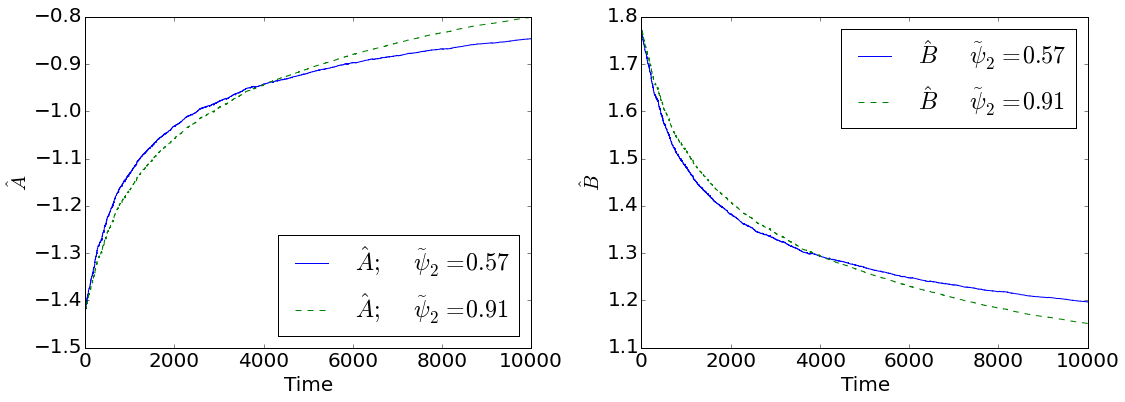

In [38]:
# Plot the results - Figure C4


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)

# Plot the results - Add RE on top

# Create a new plot
plt.figure(num=None, figsize=(16, 6), dpi=200, facecolor='w', edgecolor='k')

#plt.title('Learning Example 1: Illustrating the eventual convergence of parameter estimates')

# Add a subplot
plt.subplot(121)

# Plot the sample path A estimate
plt.plot(Learning2_samplepath[:, 7], label=r'$\hat{A}; \quad \tilde{\psi}_2 = 0.57$')
plt.plot(Learning4_samplepath[:, 7], label=r'$\hat{A}; \quad \tilde{\psi}_2 = 0.91$', ls='--')
plt.legend(loc=4, ncol=1)
plt.xlabel('Time')
plt.ylabel(r'$\hat{A}$')

# Add a subplot
plt.subplot(122)

# Plot the sample path B estimate
plt.plot(Learning2_samplepath[:, 8], label=r'$\hat{B} \quad \tilde{\psi}_2 = 0.57$')
plt.plot(Learning4_samplepath[:, 8], label=r'$\hat{B} \quad \tilde{\psi}_2 = 0.91$', ls='--')
plt.xlabel('Time')
plt.legend(loc=1, ncol=1)
plt.ylabel(r'$\hat{B}$')

plt.tight_layout()

plt.savefig('FigureC4.png')

In [39]:
########### BREAK ##########

# Constant Gain Learning

In [40]:
def Rt(Rt , yt):

    z = np.array( [[1.0],[yt]])
    zT = np.transpose(z)
    zzT = np.dot(z,zT)
    
    return Rt + g*(zzT - Rt)

# Code in Estimates equation

def xt(Rt , yt , e , x):

    A = x.item(0)
    B = x.item(1)
    z = np.array( [[1],[yt]])
    zT = np.transpose(x)
    zTx = np.dot(zT,z)
    Rinv = np.linalg.inv(Rt)
    Rinvz = np.dot(Rinv,z)

    return x + g*Rinvz*((tilde0 + tilde2*A + tilde2*B*ystar) + (tilde1 + tilde2*B*p)*yt - zTx + (tilde2*B + psi1*p)*e)

In [41]:
# Now code the updating class.

"""
Simulating a stochastic version of the Search Match model using stochastic recursive sequences, with Constant Gain Learning
"""

class SRS4:
    """
    Class used to simulate stochastic models.
    """

    def __init__(self, Y=None, X=None, R=None, U=None, y=None, x=None, r=None, u=None, e=0, eps=None, seed=None):
        """
        Atrributes:
            1) Y is a function - AR Process
            2) X is a function - Estimate Updating
            3) R is a function - Covariance updating
            4) U is a function - Unemployment updating            
            5) y is a number representing the initial condition of y
            6) x is a vector representing the initial condition of the coefficient estimates
            7) r is a matrix representing the initial condition of the coefficient estimate covariances
            8) u is a number representing the initial condition of u
            9) e is a number representing the initial condition for the innovations
            10) eps is a function returning a draw from distribution of innovations
        """
        self.Y, self.X, self.R, self.U, self.y, self.x, self.r, self.u, self.e, self.eps = Y, X, R, U, y, x, r, u, e, eps

        # initialize a seed the seed
        self.set_seed(seed)

    def set_seed(self, seed):
        """
        Sets the seed for the random number generator
        """
        self.seed = seed
        np.random.seed(int(self.seed))

    def update(self):
        """
        The order of this updating process cannot be changed without impacting the
        timing of the model!
        """       
        
        self.u = self.U(self.y, self.e, self.x, self.u)
        self.r = self.R(self.r, self.y)
        self.x = self.X(self.r, self.y, self.e, self.x)     
        self.y = self.Y(self.y, self.e)
        self.e = self.eps()  
        
        
    def sample_path(self, n):
        """
        Generates path of length n for the endogenous variables
        Note: Don't try to jam arrays into elements of the matrix
        b0=b.item(1)
        """
        path = np.zeros(shape=(n, 9))
        for t in range(n):
            path[t, 0] = self.u
            path[t, 1] = self.e
            path[t, 2] = self.y
            path[t, 3] = self.r.item(0)
            path[t, 4] = self.r.item(1)
            path[t, 5] = self.r.item(2)
            path[t, 6] = self.r.item(3)
            path[t, 7] = self.x.item(0)
            path[t, 8] = self.x.item(1)
            self.update()
        return path
 

In [42]:
### NOTE ####
## Change sample path row of productivity from 9 to 2

In [43]:
# Reset parameter values

g = 0.05
b = 0.8
beta = 0.67
alpha = 0.67
c = 0.25
# Solve for analytic equilibrium values of theta

from scipy.optimize import fsolve

def f_analytic_theta(theta):
    """   
    Returns:
    """
    
    # wage
    x = (1-beta)*(y-b) - (r+lam)*c*theta**alpha/mu - beta*c*theta
    
    return x

from scipy.optimize import newton
analytic_theta = optimize.newton(func = f_analytic_theta, x0 = 1, tol=1.48e-08)

print (analytic_theta)

psi0 = analytic_theta*(1-(1-lam)*d + beta*mu*d*analytic_theta**(1-alpha)/alpha)-mu*(1-beta)*d/(c*alpha)*analytic_theta**(1-alpha)*y
psi1 = mu*(1-beta)*d/(c*alpha)*analytic_theta**(1-alpha)
psi2 = (1-lam)*d - beta*mu*d*analytic_theta**(1-alpha)/alpha
tilde0 = psi0 + psi1*ystar*(1+p)
tilde1 = psi1*p**2
tilde2 = psi2
A = tilde0/(1-tilde2) + (tilde1*tilde2*ystar)/((1-tilde2)*(1-tilde2*p))
B = tilde1/(1-tilde2*p)
C = tilde1*tilde2/(1-tilde2*p) + psi1*p
print (A)
print (B) 

0.350339445526
-0.70427771371
1.05461715924


In [44]:
# Re-initialise and create sample path - extend length of sample path to check convergence of parameter estimates...

Learning5 = SRS4(Y=Yt, X=xt, R=Rt, U=utALM, eps=eps, seed=42)

# Set some initial conditions (stop and think about what REASONABLE initial conditions might be!)

# Note, with our timing, initial b is b_(-1), likewise for P_(-1)

x = np.array([[analytic_theta-1.77],[1.77]])
x = x.astype(float) 
y0 = y
z0 = np.array( [[1.0],[y0]])
z0T = np.transpose(z0)
z0z0T = np.dot(z0,z0T)
u1 = u1 = lam/(lam+mu*thetaALM(y, 0, x.item(0), x.item(1))**(1-alpha))
S0 = np.array([[49.0,49.00],[49.00,49.0684]])
S0 = S0.astype(float)
r0 = S0/49 
x0 = x  


# initialize X, Y and Z
Learning5.y = y0
Learning5.x = x0
Learning5.r = r0
Learning5.u = u1

# display the initial values, and the seed
print ("Initial value for the level of productivity is: ", Learning5.y)
print ("Initial value for the level of unemployment is: ", Learning5.u)
print ("Initial R matrix is: ", Learning5.r)
print ("Initial vector estimate: ", Learning5.x)
print ("Value of the seed: ", Learning5.seed)

Learning5_samplepath = Learning5.sample_path(100)

('Initial value for the level of productivity is: ', 1)
('Initial value for the level of unemployment is: ', 0.05487179295046887)
('Initial R matrix is: ', array([[ 1.        ,  1.        ],
       [ 1.        ,  1.00139592]]))
('Initial vector estimate: ', array([[-1.41966055],
       [ 1.77      ]]))
('Value of the seed: ', 42)


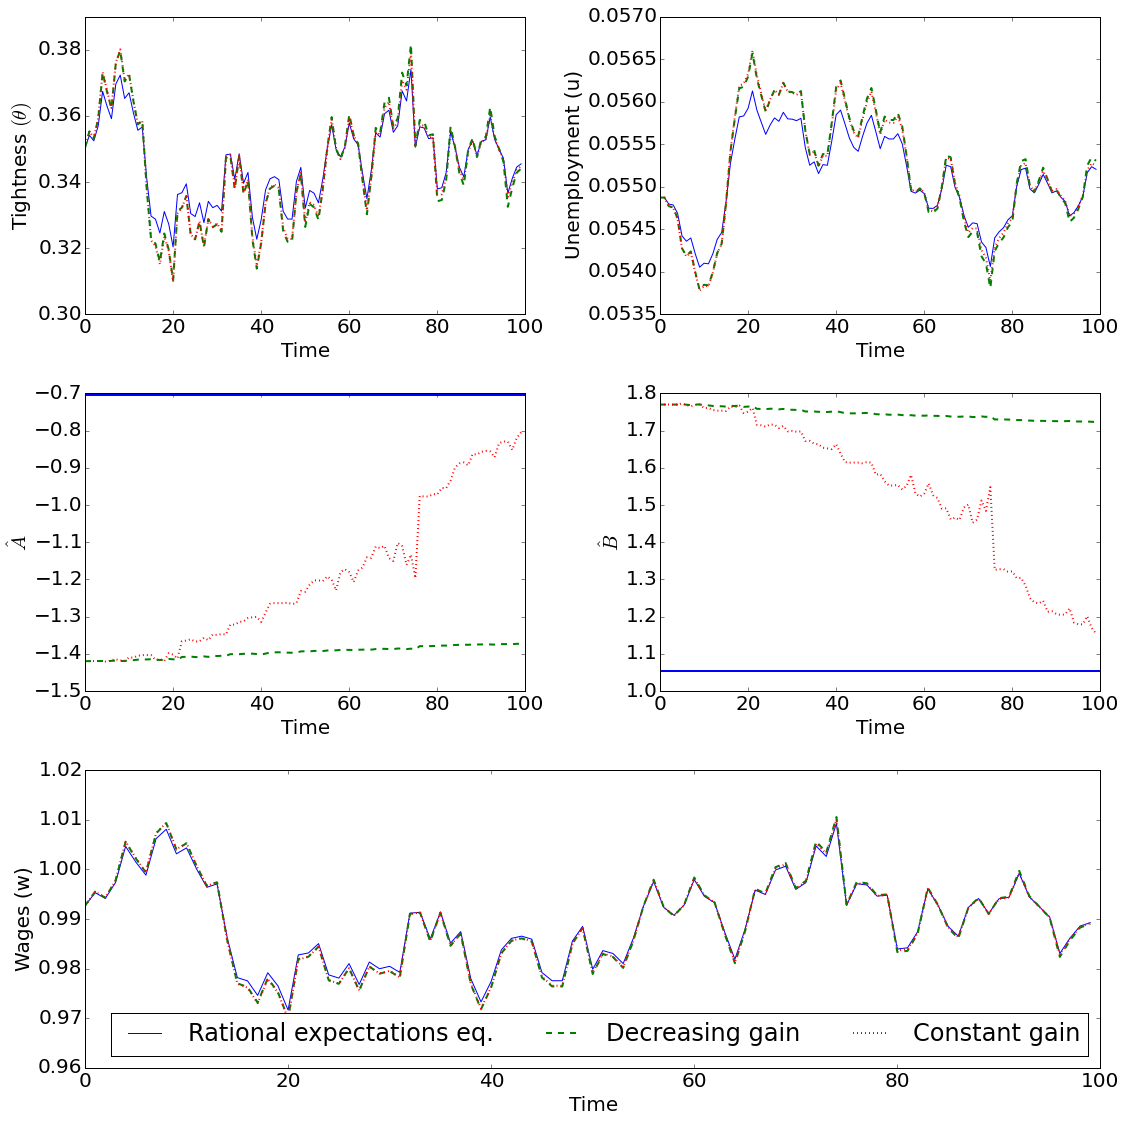

In [45]:
# Plot the results and comparisons - Figure 2

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)

# Create a new plot
plt.figure(num=None, figsize=(16, 16), dpi=200, facecolor='w', edgecolor='k')

# Add a subplot
plt.subplot(313)

# Plot the sample path of wages
plt.plot(wage_curve2(RE_samplepath[:, 0],Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]),RE_samplepath[:, 1]), label='Rational expectations eq.' )
plt.plot(wage_curve2(Learning_samplepath[:, 9], thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8]), Learning_samplepath[:, 1]), label='Decreasing gain', ls='--', linewidth=2)
plt.plot(wage_curve2(Learning5_samplepath[:, 2], thetaALM(Learning5_samplepath[:, 2], Learning5_samplepath[:, 1], Learning5_samplepath[:, 7], Learning5_samplepath[:, 8]), Learning5_samplepath[:, 1]), label='Constant gain', ls=':', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Wages (w)')
plt.legend(loc=4, ncol=3)


# Add a subplot
plt.subplot(321)

# Plot the sample path of theta
plt.plot(Thetat(RE_samplepath[:, 0],RE_samplepath[:, 1]), label=r'$\theta_{RE}$')
plt.plot(thetaALM(Learning_samplepath[:, 9], Learning_samplepath[:, 1], Learning_samplepath[:, 7], Learning_samplepath[:, 8]), label=r'$\theta_{DG}$', ls='--', linewidth=2)
plt.plot(thetaALM(Learning5_samplepath[:, 2], Learning5_samplepath[:, 1], Learning5_samplepath[:, 7], Learning5_samplepath[:, 8]), label=r'$\theta_{CG}$', ls=':', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Tightness' ' ' r'$(\theta)$')

# Add a subplot
plt.subplot(322)

# Plot the sample path of unemployment
plt.plot(RE_samplepath[:, 2], label=r'$u_{RE}$')
plt.plot(Learning_samplepath[:, 0], label=r'$u_{DG}$', ls='--', linewidth=2)
plt.plot(Learning5_samplepath[:, 0], label=r'$u_{CG}$', ls=':', linewidth=2)
# Add a subplot
plt.xlabel('Time')
plt.ylabel('Unemployment (u)')

# Add a subplot
plt.subplot(323)

# Plot the sample path A estimate
plt.plot(Learning_samplepath[:, 7], label=r'$\hat{A}_{DG}$', ls='--', color='g', linewidth=2)
plt.plot(Learning5_samplepath[:, 7], label=r'$\hat{A}_{CG}$', ls=':', color='r', linewidth=2)
plt.axhline(y=-0.70427771371, xmin=0, xmax=99, linewidth=2, color = 'b')

plt.xlabel('Time')
plt.ylabel(r'$\hat{A}$')

# Add a subplot
plt.subplot(324)

# Plot the sample path B estimate
plt.plot(Learning_samplepath[:, 8], label=r'$\hat{B}_{DG}$', ls='--', color='g', linewidth=2)
plt.plot(Learning5_samplepath[:, 8], label=r'$\hat{B}_{CG}$', ls=':', color='r', linewidth=2)
plt.axhline(y=1.05461715924, xmin=0, xmax=99, linewidth=2, color = 'b')

plt.xlabel('Time')
plt.ylabel(r'$\hat{B}$')

plt.tight_layout()

plt.savefig('Figure2.png')

In [46]:
print (np.std(wage_curve2(Learning5_samplepath[0:20, 2], thetaALM(Learning5_samplepath[0:20, 2], Learning5_samplepath[0:20, 1], Learning5_samplepath[0:20, 7], Learning5_samplepath[0:20, 8]), Learning5_samplepath[0:20, 1])))
print (np.std(wage_curve2(Learning5_samplepath[:, 2], thetaALM(Learning5_samplepath[:, 2], Learning5_samplepath[:, 1], Learning5_samplepath[:, 7], Learning5_samplepath[:, 8]), Learning5_samplepath[:, 1])))
print (np.min(wage_curve2(Learning5_samplepath[:, 2], thetaALM(Learning5_samplepath[:, 2], Learning5_samplepath[:, 1], Learning5_samplepath[:, 7], Learning5_samplepath[:, 8]), Learning5_samplepath[:, 1])))
print (np.max(wage_curve2(Learning5_samplepath[:, 2], thetaALM(Learning5_samplepath[:, 2], Learning5_samplepath[:, 1], Learning5_samplepath[:, 7], Learning5_samplepath[:, 8]), Learning5_samplepath[:, 1])))

#Theta
print (np.std(thetaALM(Learning5_samplepath[0:20, 2], Learning5_samplepath[0:20, 1], Learning5_samplepath[0:20, 7], Learning5_samplepath[0:20, 8])))
print (np.std(thetaALM(Learning5_samplepath[:, 2], Learning5_samplepath[:, 1], Learning5_samplepath[:, 7], Learning5_samplepath[:, 8])))
print (np.min(thetaALM(Learning5_samplepath[:, 2], Learning5_samplepath[:, 1], Learning5_samplepath[:, 7], Learning5_samplepath[:, 8])))
print (np.max(thetaALM(Learning5_samplepath[:, 2], Learning5_samplepath[:, 1], Learning5_samplepath[:, 7], Learning5_samplepath[:, 8])))
                
#Unemployment
print (np.std(Learning5_samplepath[0:20, 0]))
print (np.std(Learning5_samplepath[:, 0]))
print (np.min(Learning5_samplepath[:, 0]))
print (np.max(Learning5_samplepath[:, 0]))

0.0115847546957
0.00909028570243
0.969892256182
1.01011404848
0.0206865003601
0.0157075019523
0.309842649375
0.380086402764
0.000733145890222
0.000691239934554
0.0537758713277
0.0566024847855


In [47]:
 ### END ###